# SynthCheck:A Synthetic Image Identification Using Deep Learning

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG19
import numpy as np

C:\Users\vaibh\.conda\envs\tensorflow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load image dataset
data = tf.keras.utils.image_dataset_from_directory(r"D:\## BE Sem II\Project stage II\Cifake Dataset\TRAIN", image_size=(32, 32))

Found 11138 files belonging to 2 classes.


0.0
255.0


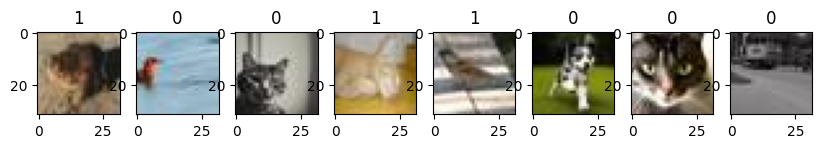

In [3]:
# Visualize a batch of images
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

print(batch[0].min())
print(batch[0].max())

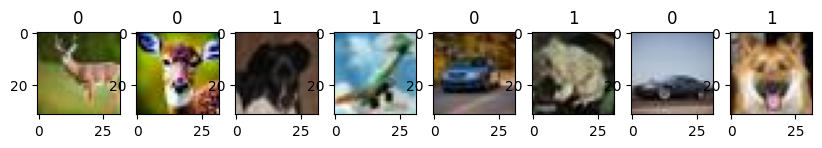

In [4]:
# Scale pixel values to the range [0, 1]
data = data.map(lambda x, y : (x/255, y))

# Visualize a scaled batch of images
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])


In [5]:
# Split the dataset
train_size = int(len(data) * 0.7)
cv_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size + cv_size).take(test_size)

print(len(train) + len(cv) + len(test))


348


In [6]:
# Define a VGG19 model for image classification
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg_model.trainable = False  

In [7]:
# Create a new model by adding a few layers on top of the VGG19 model
vgg_based_model = models.Sequential()
vgg_based_model.add(vgg_model)
vgg_based_model.add(layers.Flatten())
vgg_based_model.add(layers.Dense(256, activation='relu'))
vgg_based_model.add(layers.BatchNormalization())
vgg_based_model.add(layers.Dropout(0.5))
vgg_based_model.add(layers.Dense(128, activation='relu'))
vgg_based_model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# Learning rate scheduler for the VGG19-based model
vgg_initial_learning_rate = 0.001
vgg_lr_schedule = LearningRateScheduler(lambda epoch, lr: lr * 0.95)
vgg_optimizer = Adam(learning_rate=vgg_initial_learning_rate)


In [9]:
# Compile the VGG19-based model
vgg_based_model.compile(optimizer=vgg_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the VGG19-based model
vgg_history = vgg_based_model.fit(data, validation_data=cv, epochs=10, callbacks=[vgg_lr_schedule])


Epoch 1/10
349/349 [==============================] - 53s 149ms/step - loss: 0.4852 - accuracy: 0.7693 - val_loss: 0.3714 - val_accuracy: 0.8297 - lr: 9.5000e-04
Epoch 2/10
349/349 [==============================] - 55s 157ms/step - loss: 0.4131 - accuracy: 0.8087 - val_loss: 0.3678 - val_accuracy: 0.8279 - lr: 9.0250e-04
Epoch 3/10
349/349 [==============================] - 56s 161ms/step - loss: 0.3923 - accuracy: 0.8227 - val_loss: 0.3397 - val_accuracy: 0.8546 - lr: 8.5737e-04
Epoch 4/10
349/349 [==============================] - 56s 161ms/step - loss: 0.3790 - accuracy: 0.8293 - val_loss: 0.3233 - val_accuracy: 0.8578 - lr: 8.1451e-04
Epoch 5/10
349/349 [==============================] - 57s 164ms/step - loss: 0.3588 - accuracy: 0.8416 - val_loss: 0.3093 - val_accuracy: 0.8664 - lr: 7.7378e-04
Epoch 6/10
349/349 [==============================] - 65s 185ms/step - loss: 0.3517 - accuracy: 0.8458 - val_loss: 0.2988 - val_accuracy: 0.8723 - lr: 7.3509e-04
Epoch 7/10
349/349 [========

In [11]:
# Evaluate the VGG19-based model on the test set
vgg_test_loss, vgg_test_accuracy = vgg_based_model.evaluate(test)
print(f'VGG19 Test Accuracy: {vgg_test_accuracy * 100:.2f}%')


35/35 [==============================] - 6s 108ms/step - loss: 0.2356 - accuracy: 0.9009
VGG19 Test Accuracy: 90.09%


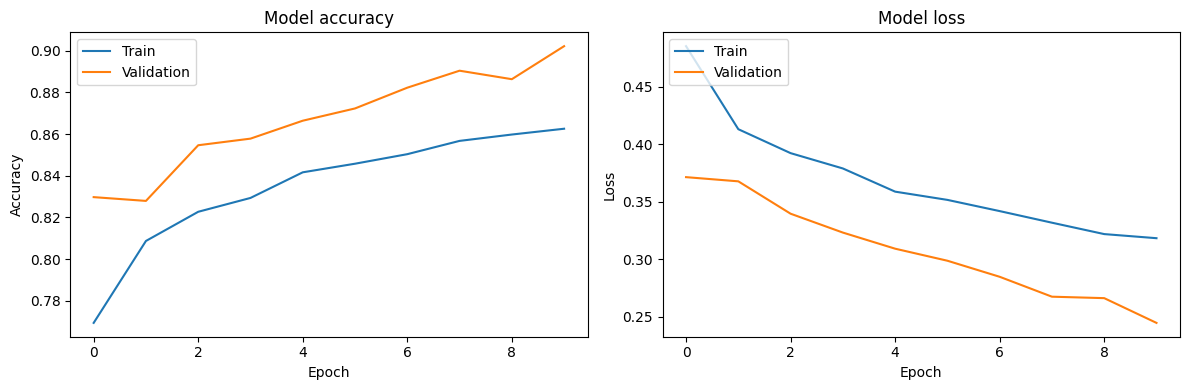

In [12]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [13]:
from tensorflow.keras.metrics import Precision, Recall

pre = Precision()
rec = Recall()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = vgg_based_model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)


1/1 [==============================] - 0s 173ms/step


In [14]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}')


Precision: 0.8948453664779663, Recall: 0.8732394576072693


In [15]:
from tensorflow.keras.models import load_model
from keras.models import load_model

# Assuming 'model' is your Keras model
vgg_based_model.save('model/ai_imageclassifier', save_format='tf')

loaded_model = tf.keras.models.load_model('model/ai_imageclassifier')

INFO:tensorflow:Assets written to: model/ai_imageclassifier\assets


INFO:tensorflow:Assets written to: model/ai_imageclassifier\assets


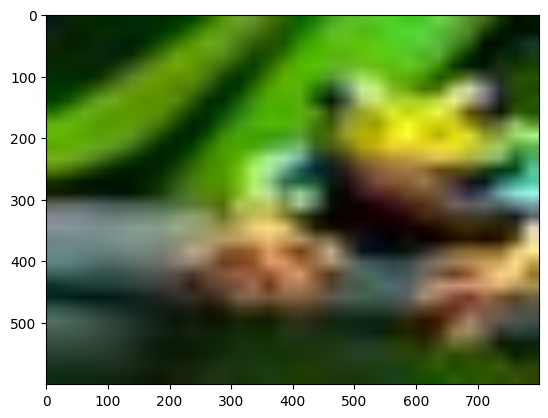

In [16]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = r"D:\## BE Sem II\Project stage II\Cifake Dataset\TEST\FAKE\66 (7).jpg"

try:
    img = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")

    # Resize the image to a larger size
    img = cv2.resize(img, (800, 600))

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the resized image
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")


In [17]:
resize = tf.image.resize(img, (32, 32))

y_pred = vgg_based_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 156ms/step


In [18]:
y_pred

array([[0.01600822]], dtype=float32)

In [19]:
if y_pred > 0.5: 
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: SYNTHETIC')

Predicted class: SYNTHETIC
